# Phase 3 project

## Covid Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
df_covid=pd.read_csv('Covid Data.csv')

In [3]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


### Copying description from Kaggle

About Dataset
Context
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

### content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

I need to decide which one should be the target variable. The possible ones are:
'classification', 'patient type', 'usmr', 'medical unit', 'icu', 'date died'

In [4]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
df_covid['USMER'].value_counts

<bound method IndexOpsMixin.value_counts of 0          2
1          2
2          2
3          2
4          2
          ..
1048570    2
1048571    1
1048572    2
1048573    2
1048574    2
Name: USMER, Length: 1048575, dtype: int64>

In [6]:
df_covid['USMER'].value_counts(normalize=True)

2    0.632194
1    0.367806
Name: USMER, dtype: float64

In [7]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

7    0.476122
3    0.363853
6    0.122197
5    0.024882
1    0.008203
4    0.002977
2    0.001765
Name: CLASIFFICATION_FINAL, dtype: float64

I would need to do a groupby here because values 1-3 mean they had covid, 4 and up no covid.
I think whichever target variable I choose I have to remove all the other info we have about the patient having covid.

In [8]:
df_covid['PATIENT_TYPE'].value_counts(normalize=True)

1    0.809235
2    0.190765
Name: PATIENT_TYPE, dtype: float64

This could be good but it is imbalanced. But maybe even like this it is ok.

In [9]:
df_covid['MEDICAL_UNIT'].value_counts(normalize=True)

12    0.575061
4     0.299840
6     0.038704
9     0.036350
3     0.018287
8     0.009917
10    0.007508
5     0.006908
11    0.005319
13    0.000950
7     0.000850
2     0.000161
1     0.000144
Name: MEDICAL_UNIT, dtype: float64

In [10]:
# Not very informative

In [11]:
df_covid['ICU'].value_counts(normalize=True)

97    0.809235
2     0.167546
1     0.016077
99    0.007141
Name: ICU, dtype: float64

In [12]:
# Mostly missing values

In [13]:
df_covid['DATE_DIED'].value_counts(normalize=True)

9999-99-99    9.266223e-01
06/07/2020    9.536752e-04
07/07/2020    9.498605e-04
13/07/2020    9.441385e-04
16/06/2020    9.336480e-04
                  ...     
07/10/2020    9.536752e-07
19/12/2020    9.536752e-07
19/01/2021    9.536752e-07
05/12/2020    9.536752e-07
06/01/2021    9.536752e-07
Name: DATE_DIED, Length: 401, dtype: float64

In [14]:
# Mostly missing values

Stays standing 'classification', 'patient type'

To make the decision between these two variables we did some research to gain some domain knowledge and spoke directly to some first responders during the covid 19 pandemic, that suggested that the information about whether or not a patient needed to be hospitalized was more valuable than the results of the covid test.
This is the case since some patients might have tested positive for covid 19, but because of mild symptoms and overall good health were sent back home to be treated, and what actually really put a strain on health structures was the number of people in need to be hospitalized. Because of this we are going to use 'patient type' as our target for this study.
We are also going to drop all the other variables related to hospitalization since those contain knowledge about the hospitalization of the patient, while what we are trying to predict is the amout of people that would need to be hospitalized, based on previous knowledge so this is not a type of information we would have, if we wanted to use the model again on other data.

So target should be patient type and all the other hospital related variables should be dropped.

In [15]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [16]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [17]:
df=df_covid.drop(['USMER', 'MEDICAL_UNIT', 'INTUBED', 'CLASIFFICATION_FINAL', 'ICU', 'DATE_DIED'], axis=1)

In [18]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2
1,2,1,1,72,97,2,2,2,2,1,2,2,1,1,2
2,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2
3,1,1,2,53,2,2,2,2,2,2,2,2,2,2,2
4,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,1,2,40,97,2,2,2,2,2,2,2,2,2,2
1048571,2,2,2,51,97,2,2,2,2,1,2,2,2,2,2
1048572,2,1,2,55,97,2,2,2,2,2,2,2,2,2,2
1048573,2,1,2,28,97,2,2,2,2,2,2,2,2,2,2


The missing values are catalogued as 97 or 99. So I have to look for these values to understand how many null values.

Will need to find a way to replace the missing values for pregnant.

In [19]:
for i in df.columns:
    print(df[i].value_counts())
    print("\n")

1    525064
2    523511
Name: SEX, dtype: int64


1    848544
2    200031
Name: PATIENT_TYPE, dtype: int64


2     892534
1     140038
99     16003
Name: PNEUMONIA, dtype: int64


30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
115        2
114        2
113        1
111        1
121        1
Name: AGE, Length: 121, dtype: int64


97    523511
2     513179
1       8131
98      3754
Name: PREGNANT, dtype: int64


2     920248
1     124989
98      3338
Name: DIABETES, dtype: int64


2     1030510
1       15062
98       3003
Name: COPD, dtype: int64


2     1014024
1       31572
98       2979
Name: ASTHMA, dtype: int64


2     1031001
1       14170
98       3404
Name: INMSUPR, dtype: int64


2     882742
1     162729
98      3104
Name: HIPERTENSION, dtype: int64


2     1015490
1       28040
98       5045
Name: OTHER_DISEASE, dtype: int64


2     1024730
1       20769
98       3076
Name: CARDIOVASCULAR, dtype: int64


2     885727
1     159816
98      3032
Nam

97, 98 and 99 represent missing values for all the columns except 'AGE'.
<br>For some categories the missing values are so little that it's worth just dropping them. For the two categories with the most missing values, 'PREGNANT' and 'PNEUMONIA' we will proceed to impute them.

We will temporarily remove the 'age' column as in this one 97, 98 and 99 are actually real values and not missing values.
<br> We will work on this column first to remove the outliers, then we will drop it from the dataset and reeinsert it once we dealt with the missing values for the other columns.

In [20]:
age=df['AGE']

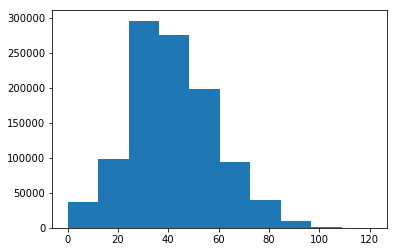

In [21]:
plt.hist(age);

Even if we cannot be certain about this, since there is no information about this on the dataset, we can safely assume that values for age that are above 110 are probably typos or outliers. It might also be the way that it was inputed when the value of 'age' for that patient was missing: since there are no NaN values and yet, 97 98 and 99 which were used in the other columns to indicate missing values, clearly cannot be used in this one.
So we will remove the columns that have the age value>110.

In [22]:
df.drop(df.loc[df['AGE']>110].index, inplace=True)

In [23]:
df['AGE'].value_counts()

30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
105        7
109        6
110        6
107        5
106        4
Name: AGE, Length: 111, dtype: int64

Now that we have taken care of the outliers for this column in the Dataframe we can remove it to add it again once we finish the rest of the data processing.

In [24]:
df.drop('AGE', axis=1, inplace=True)

In [25]:
for i in df.columns:
    df[i]=df[i].replace([97,98,99], np.NaN)

In [26]:
df.isna().sum()

SEX                    0
PATIENT_TYPE           0
PNEUMONIA          16003
PREGNANT          527251
DIABETES            3338
COPD                3003
ASTHMA              2979
INMSUPR             3404
HIPERTENSION        3104
OTHER_DISEASE       5045
CARDIOVASCULAR      3076
OBESITY             3032
RENAL_CHRONIC       3006
TOBACCO             3219
dtype: int64

In [27]:
"""I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.
For now let me replace them in this easier percentage way, then if I have time later I will try the other two ways."""

'I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.\nFor now let me replace them in this easier percentage way, then if I have time later I will try the other two ways.'

As we saw before most missing values are in the columns "PREGNANT" and "PNEUMONIA".
<br>We want to replace them but not just with the mode, but keeping the same percentage of values from the original data.
<br>We will use the percentages that we saw in the above value counts, to keep the data distributed as it was originally.

In [28]:
df['PREGNANT'] =df['PREGNANT'].fillna(pd.Series(np.random.choice([1, 2], 
                                    p=[0.02,0.98],size=len(df))))

In [29]:
df['PNEUMONIA'] =df['PNEUMONIA'].fillna(pd.Series(np.random.choice([1, 2], 
                                    p=[0.14,0.86],size=len(df))))

In [30]:
df=pd.concat([df, age], axis=1)

In [31]:
df.dropna(inplace=True)

In [32]:
df.isna().sum()

SEX               0
PATIENT_TYPE      0
PNEUMONIA         0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
AGE               0
dtype: int64

In [33]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,65
1,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,72
2,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
3,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,53
4,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048563,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,46
1048564,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,30
1048565,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,39
1048567,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,23


Now to follow the usual convention of one hot encoding I want to change the values 2 which means no into 0.
<br>This is true for all the columns except our target, 'PATIENT_TYPE' where 1 means they returned home and 2 means they were hospitalized. I will do this separately, and then assign the column to y.
For X I will do the necessary changes to df and then concat with 'AGE' that I dropped before.
<br>For sex it is going to be 1 for female and 0 for male.

In [34]:
y=df['PATIENT_TYPE']

In [35]:
#I have to redifine age again because the old onw has some null values that I dropped.
age=df['AGE']

In [36]:
df.drop(['PATIENT_TYPE','AGE'], axis=1, inplace=True)

In [37]:
df=df.replace(2, 0)

In [38]:
df

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048563,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048564,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1048565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048567,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
for i in df.columns:
    print(i,'\n', df[i].value_counts(normalize=True))

SEX 
 1.0    0.501233
0.0    0.498767
Name: SEX, dtype: float64
PNEUMONIA 
 0.0    0.865639
1.0    0.134361
Name: PNEUMONIA, dtype: float64
PREGNANT 
 0.0    0.982168
1.0    0.017832
Name: PREGNANT, dtype: float64
DIABETES 
 0.0    0.880901
1.0    0.119099
Name: DIABETES, dtype: float64
COPD 
 0.0    0.985698
1.0    0.014302
Name: COPD, dtype: float64
ASTHMA 
 0.0    0.969851
1.0    0.030149
Name: ASTHMA, dtype: float64
INMSUPR 
 0.0    0.986561
1.0    0.013439
Name: INMSUPR, dtype: float64
HIPERTENSION 
 0.0    0.844847
1.0    0.155153
Name: HIPERTENSION, dtype: float64
OTHER_DISEASE 
 0.0    0.973249
1.0    0.026751
Name: OTHER_DISEASE, dtype: float64
CARDIOVASCULAR 
 0.0    0.980277
1.0    0.019723
Name: CARDIOVASCULAR, dtype: float64
OBESITY 
 0.0    0.847611
1.0    0.152389
Name: OBESITY, dtype: float64
RENAL_CHRONIC 
 0.0    0.982012
1.0    0.017988
Name: RENAL_CHRONIC, dtype: float64
TOBACCO 
 0.0    0.919502
1.0    0.080498
Name: TOBACCO, dtype: float64


Changing to zero and 1 for the target:

In [40]:
y=y.replace(1,0)
y=y.replace(2, 1)
y

0          0.0
1          0.0
2          1.0
3          0.0
4          0.0
          ... 
1048563    0.0
1048564    0.0
1048565    0.0
1048567    1.0
1048569    1.0
Name: PATIENT_TYPE, Length: 1040977, dtype: float64

In [41]:
y.value_counts()

0.0    844030
1.0    196947
Name: PATIENT_TYPE, dtype: int64

In [42]:
X=pd.concat([df,age], axis=1)

In [43]:
X

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,72
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048563,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46
1048564,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30
1048565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39
1048567,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23


At this point I took care of the missing values and I don't need to do one hot encoding.
<br>I have my X and y, I can divide in train and test and start trying some models.
<br>But if I want to use KNN first (and I do) I have to scale first, specifically age needs to be scaled.

In [44]:
"""Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that."""

'Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that.'

In [45]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [46]:
# Instantiate StandardScaler
scaler = MinMaxScaler()
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert into a DataFrame
X_train = pd.DataFrame(scaled_data_train, columns=X.columns)
X_train.head()

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327273
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.672727
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345455
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481818
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.400000


In [47]:
#Create the tree
clf = DecisionTreeClassifier(criterion='entropy')

In [48]:
# fit the tree
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [49]:
"""# plot the tree
fig, axes = plt.subplots()#nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()"""

"# plot the tree\nfig, axes = plt.subplots()#nrows = 1,ncols = 1, figsize = (3,3), dpi=300)\ntree.plot_tree(clf,\n               feature_names = X_train.columns, \n               class_names=np.unique(y).astype('str'),\n               filled = True)\nplt.show()"

In [50]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [51]:
# Evaluate the tree
print("For the train with decision tree:\n")
y_preds_train = clf.predict(X_train)
print_metrics(y_train, y_preds_train)

For the train with decision tree:

Precision Score: 0.841324314316936
Recall Score: 0.6303599098702863
Accuracy Score: 0.9075252455388021
F1 Score: 0.7207213480016711


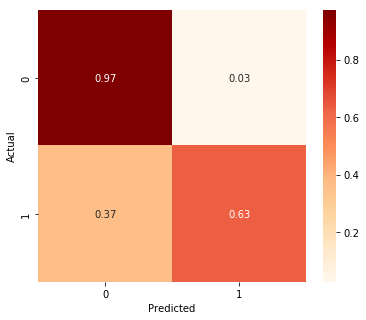

In [52]:
cm = confusion_matrix(y_train, y_preds_train)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="OrRd")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [53]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    #not sure why when I add np.sort in front of model feature it changes
    plt.barh(range(n_features), (model.feature_importances_), align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

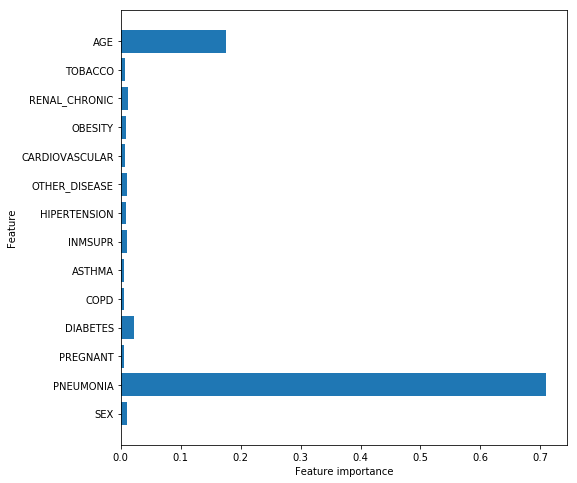

In [54]:
plot_feature_importances(clf)

In [55]:
def model_results(model):
    with plt.style.context('seaborn-talk'):
        y_preds_train=model.predict(X_train)
        cm = confusion_matrix(y_train, y_preds_train)
        # Normalize
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(cmn, annot=True, fmt='.2f', cmap="OrRd")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show(block=False)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
        # Create Confusion Matrix for the test set
#        plot_confusion_matrix(model, X_train, y_train, normalize = 'true', ax=ax1,  cmap = 'Greens')
#        ax1.grid(False)
#        ax1.set_title("Train Confusion Matrix")
        # Create Roc curve for the test and train for TP and FP rates
        plot_roc_curve(model, X_train, y_train, ax=ax2, color='green', name ='Train ROC curve')
#        plot_roc_curve(model, X_test, y_test, ax=ax2, color = ‘blue’, name ='Test ROC curve' )
        ax2.plot([0, 1], [0, 1], color='black', lw=2, linestyle='-')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
        plt.show()
        #Create a classification report
        y_pred = model.predict(X_train)
#        print(classification_report(y_train, y_pred))
        ######***NEW LINE*** Print CV ROC_AUC score, and roc_auc score for test/train
#Print CV ROC_AUC score
        plot_feature_importances(model)
#        roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train,
#                                        cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
#        print(f"Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.0%}")
        #print roc_auc for test and train
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        print(f"Train Roc_Auc Score: {roc_score_train :.0%}")
#        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
#        print(f”Test Roc_Auc Score: {roc_score_test :.0%}“)
        accuracy_train = model.score(X_train, y_train)
#        accuracy_test = model.score(X_test, y_test)
        print(f"Train Accuracy Score: {accuracy_train :.0%}")
#        print(f”Test Accuracy Score: {accuracy_test :.0%}“)

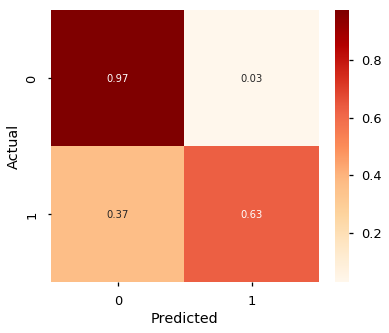

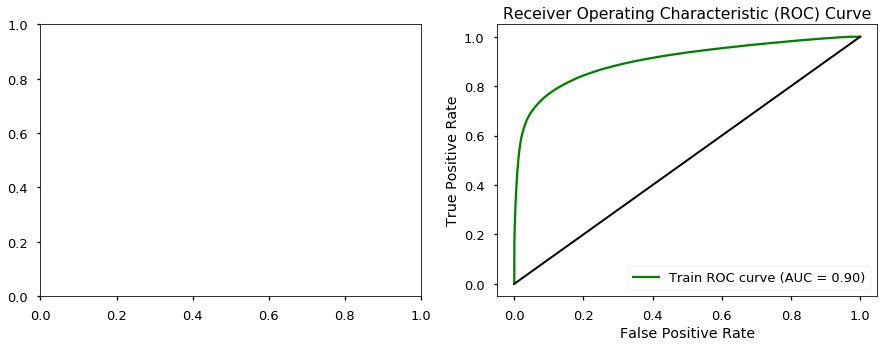

Train Roc_Auc Score: 90%
Train Accuracy Score: 91%


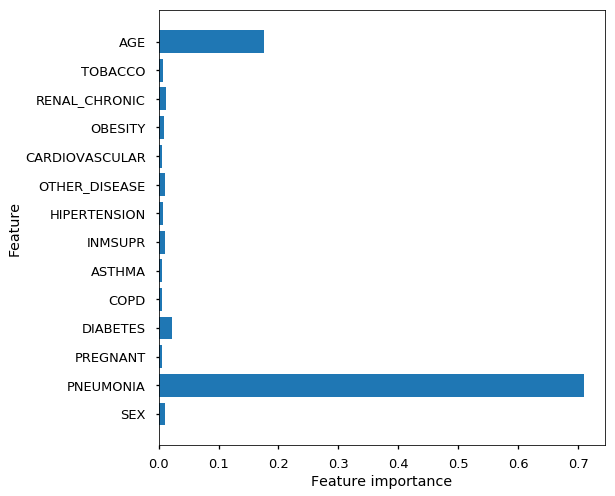

In [56]:
model_results(clf)

### Feature importance (maybe better to do it later with most accurate model)

In [57]:
# Feature Importance
feature_used = df.columns
for fi, feature in zip(clf.feature_importances_, feature_used):
    print(fi, feature)

0.011192615389966805 SEX
0.7090442297043962 PNEUMONIA
0.0061460047810561105 PREGNANT
0.022385250938009464 DIABETES
0.005630022527831778 COPD
0.005866709130386906 ASTHMA
0.010581068730237068 INMSUPR
0.008034125039625407 HIPERTENSION
0.009948517194411931 OTHER_DISEASE
0.006341532966329145 CARDIOVASCULAR
0.008948903470295099 OBESITY
0.012140269412580808 RENAL_CHRONIC
0.007512695226193101 TOBACCO


In [58]:
print(f'Decision Tree has {clf.tree_.node_count} nodes with a maximum depth of {clf.tree_.max_depth}.')

print(f'Model Accuracy for train data: {clf.score(X_train, y_train)}')

Decision Tree has 38415 nodes with a maximum depth of 29.
Model Accuracy for train data: 0.9075252455388021


This is not so bad as a result. But given our situation I would actually like to have a higher recall than accuracy. With a high recall it means I am getting more false positives because I am decreasing the thershold, but that is what I want most times in 'medical situations', because I would rather have a false positive than a false negative.

### Class Imbalance
<br> One thing we have not considered yet is the fact that the classes of our target (patients sent home vs. patients hospitalized) are not balanced. They are not present equally in our dataset but around 80% of the patients were sent home and only 20% were hospitalized, as we saw from the split of the data for that column.
<br> This means that a very basic model that simply predicts all the patients to be sent home would have an 80% accuracy, that's the baseline.
<br> We have a way to counteract this problem by balancing the classes with a decision tree and that is what we are going to do.

In [59]:
clf_bal = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')

In [60]:
clf_bal.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

In [61]:
# Evaluate the tree
print("Results with Decision Tree considering class imbalance:\n")
ypreds_train_bal = clf_bal.predict(X_train)
print_metrics(y_train, ypreds_train_bal)

Results with Decision Tree considering class imbalance:

Precision Score: 0.6343894367448472
Recall Score: 0.7730788229005258
Accuracy Score: 0.8727079202594489
F1 Score: 0.6969010287206107


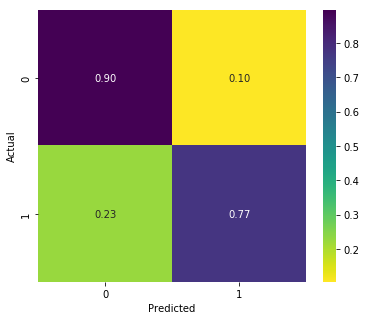

In [62]:
cm = confusion_matrix(y_train, ypreds_train_bal)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='viridis_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

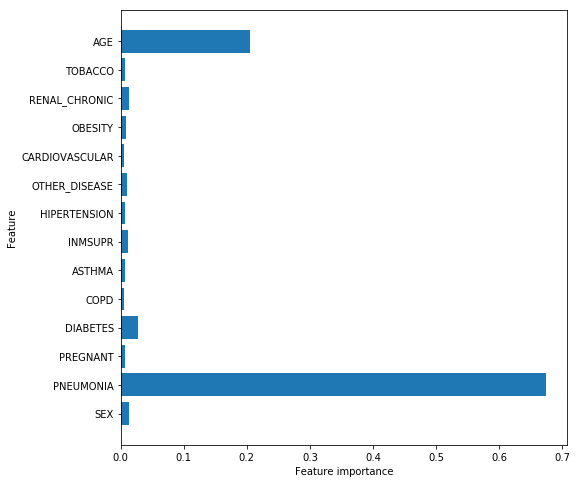

In [63]:
plot_feature_importances(clf_bal)

As we can see from the confusion matrix we started to have more False Positives and the predictions of the majority class (0, people returned home) has decreased. This reflects also in the accuracy score and F1 score.
<br> But on the bright side the predictions for the minority class (1, hospitalized) have improved, with less false negatives and a recall that went from 0.63 to 0.77.
<br> This is a matter of choice for the stakeholder, which model to use. The Decision tree without class imbalance leads to an overall more precise model: less falses overall, negative and positive, more patients categorized correctly.
<br> On the other hand the model that accounts for class imbalance makes more mistakes, has lower accurcay precision and F1 score, but it has overall less false negatives.
<br>Given the specific problem we would recommend staying on the safer side, trying to minimize the false negatives then the false positives, because it would be less of a loss to be prepared for one extra patient that doesn't ultimately need to be hospitalized, rather then not being ready with the equippment for one that actually needs to be.

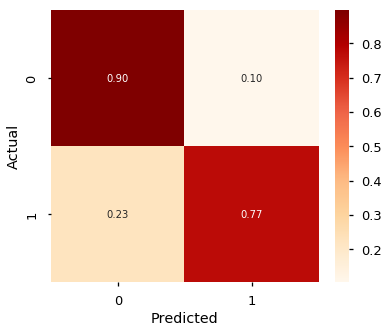

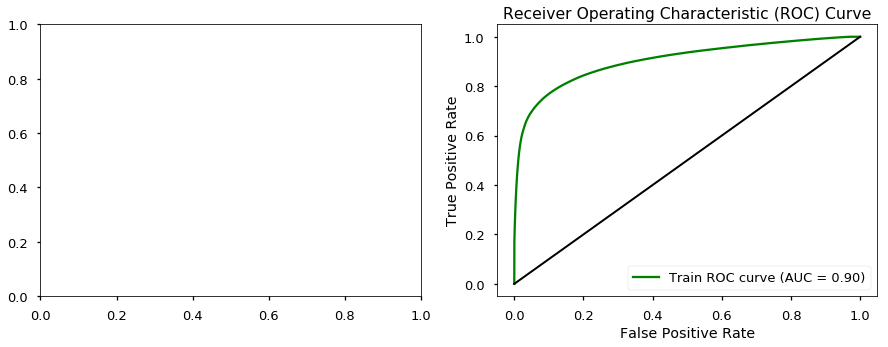

Train Roc_Auc Score: 90%
Train Accuracy Score: 87%


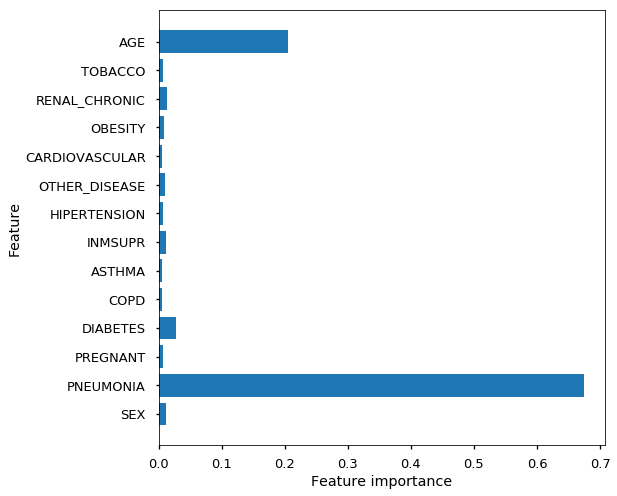

In [64]:
model_results(clf_bal)

### Logistic Regression
<br> Another simple model that we can try is Logistic Regression. I works similarly to Linear Regression but it can make predictions on categorical data, splitting continuous intervals into beams.

In [65]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=500)

Making predictions using the Train.

In [66]:
y_preds_train_log = logreg.predict(X_train)

In [67]:
print("Results for Logistic Regression:\n")

print_metrics(y_train, y_preds_train_log)

Results for Logistic Regression:

Precision Score: 0.8136729717747894
Recall Score: 0.5961146785576539
Accuracy Score: 0.8977075360046726
F1 Score: 0.6881070378311248


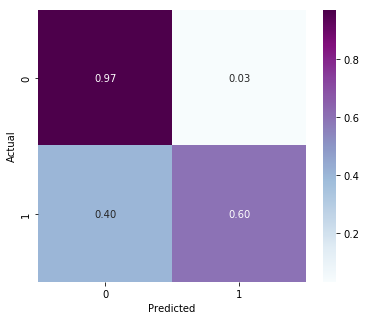

In [68]:
cm = confusion_matrix(y_train, y_preds_train_log)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='BuPu')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

The decision tree model performed better than the Logistic Regression model for every metric. So we are going to stick to that and actually use an ensemble of trees to predict our results even more accurately. To train the model on different trees what we used is a Random Forest.

In [69]:
#model_results(logreg)

### Random Forest

In [70]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(random_state=19)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=19)

In [71]:
# Training accuracy score
forest.score(X_train, y_train)

0.9075214029910392

In [72]:
ypreds_train_for=forest.predict(X_train)

In [73]:
print("Random Forest Vanilla Results:")
print_metrics(y_train, ypreds_train_for)

Random Forest Vanilla Results:
Precision Score: 0.8339961468441239
Recall Score: 0.6385541353434334
Accuracy Score: 0.9075214029910392
F1 Score: 0.7233052682407134


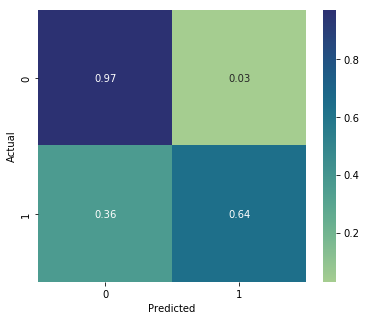

In [74]:
cm = confusion_matrix(y_train, ypreds_train_for)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='crest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [76]:
# This should be the accuracy
#mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))

In [77]:
#mean_rf_cv_score

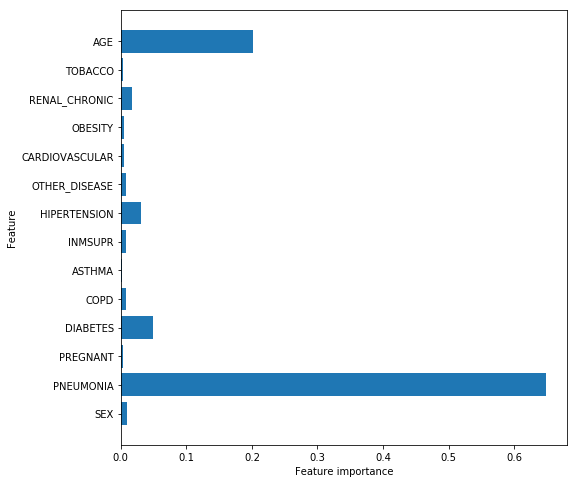

In [78]:
plot_feature_importances(forest)

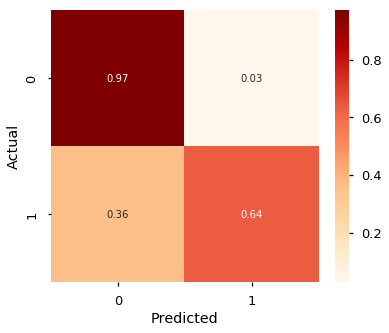

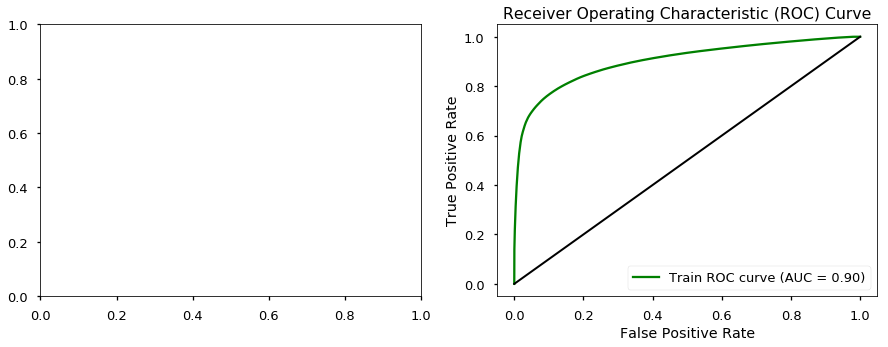

Train Roc_Auc Score: 90%
Train Accuracy Score: 91%


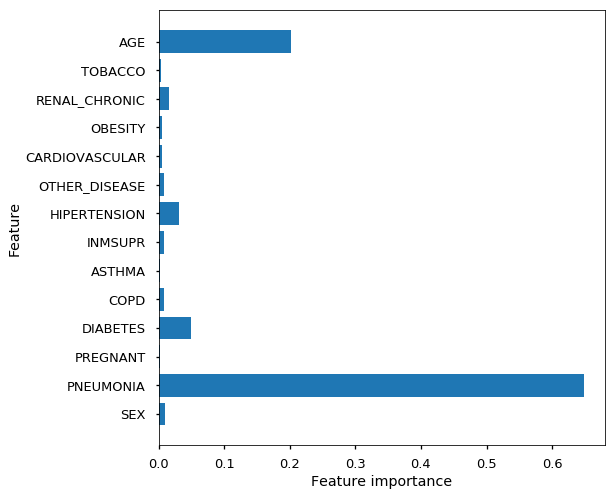

In [79]:
model_results(forest)

### GridSearchCV:

In [80]:
# create the grid with parameters:

rf_param_grid = { 'n_estimators':[10,30,100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 2,6,10],
                 'min_samples_split':[5, 10],
                 'min_samples_leaf':[3, 6]
    
}

In [81]:
"""rf_grid_search = GridSearchCV(forest, rf_param_grid,cv=3)
rf_grid_search.fit(X_train, y_train)
"""

'rf_grid_search = GridSearchCV(forest, rf_param_grid,cv=3)\nrf_grid_search.fit(X_train, y_train)\n'

Since the model took a very long time to fit I am going to pickle it, to save it for a later rerun without it having to fit again.

In [82]:
filename = 'CVforest_model.pkl'

In [83]:
""" code with which I saved the model
# save the model to disk

joblib.dump(rf_grid_search, filename)

"""

' code with which I saved the model\n# save the model to disk\n\njoblib.dump(rf_grid_search, filename)\n\n'

In [84]:
# some time later...

# load the model from disk
loaded_model = joblib.load(filename)

In [85]:
forest_accuracy=loaded_model.best_score_ 
best_params=loaded_model.best_params_

In [86]:
print(f"Testing Accuracy: {forest_accuracy:.2%}")
print("")
print(f"Best Parameters:{best_params}")

Testing Accuracy: 89.98%

Best Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 30}


### Best Forest

Then I will run a forest with those best parameters we just found:

In [87]:
best_forest = RandomForestClassifier(n_estimators= 30 , criterion= 'gini', max_depth= None, 
                                     min_samples_split=5, min_samples_leaf=6, random_state=19)
best_forest.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=6, min_samples_split=5, n_estimators=30,
                       random_state=19)

In [88]:
ypreds_train_bestfor = best_forest.predict(X_train)

In [89]:
print("Results for best Random Forest:\n")

print_metrics(y_train, ypreds_train_bestfor)

Results for best Random Forest:

Precision Score: 0.8210321516308928
Recall Score: 0.619628248763423
Accuracy Score: 0.9024313080544925
F1 Score: 0.7062520968220855


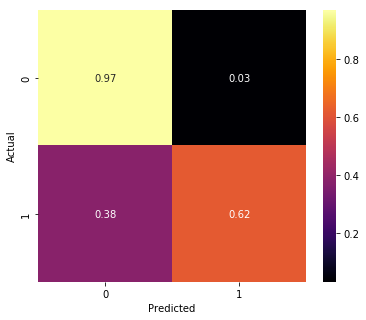

In [90]:
cm = confusion_matrix(y_train, ypreds_train_bestfor)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='inferno')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

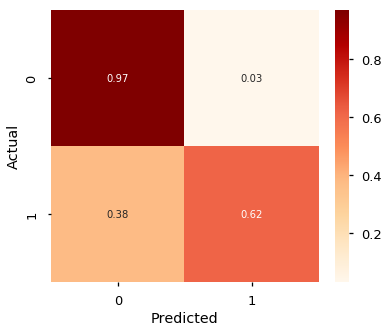

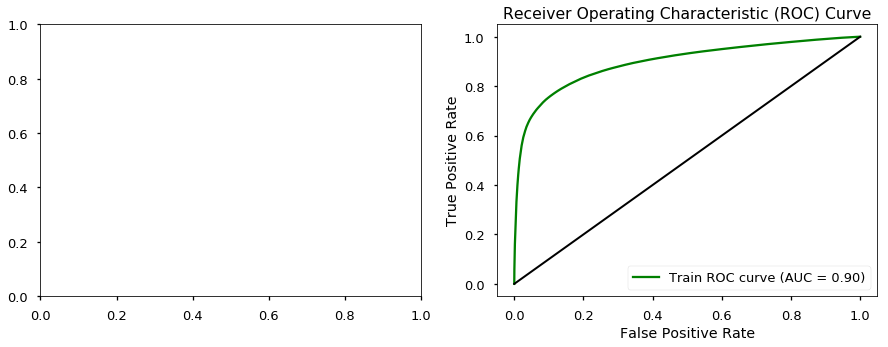

Train Roc_Auc Score: 90%
Train Accuracy Score: 90%


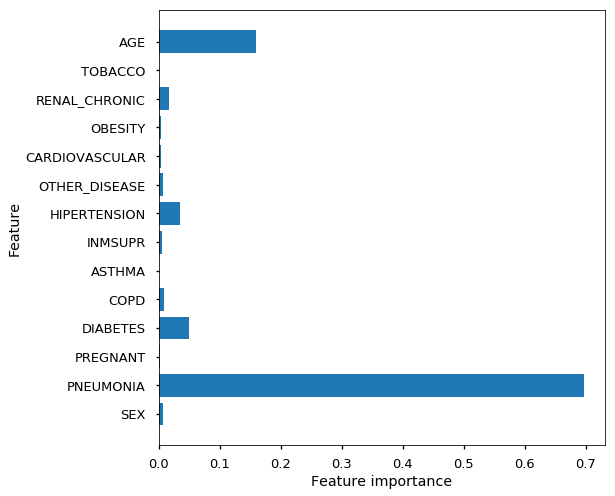

In [91]:
model_results(best_forest)

### Including class imbalance:
Now we will also use the balancing of the classes since we saw before that helped improving the recall rate:

In [92]:
best_forest_bal = RandomForestClassifier(n_estimators= 30 , criterion= 'gini', max_depth= None, 
                                     min_samples_split= 5, min_samples_leaf=6, 
                                     class_weight='balanced',random_state=19,)
best_forest_bal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       min_samples_split=5, n_estimators=30, random_state=19)

In [93]:
ypreds_train_bestfor_bal = best_forest_bal.predict(X_train)

In [94]:
print("Results for best Random Forest Balanced:\n")

print_metrics(y_train, ypreds_train_bestfor_bal)

Results for best Random Forest Balanced:

Precision Score: 0.615855114623133
Recall Score: 0.7678280227624893
Accuracy Score: 0.8653917093189468
F1 Score: 0.6834958122893721


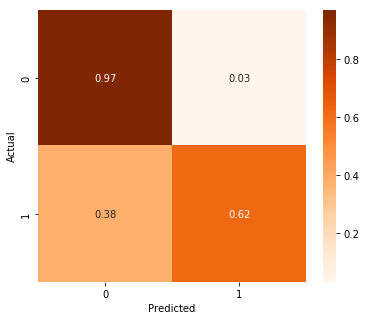

In [95]:
cm = confusion_matrix(y_train, ypreds_train_bestfor)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Oranges')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

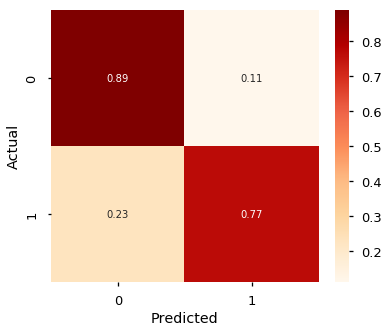

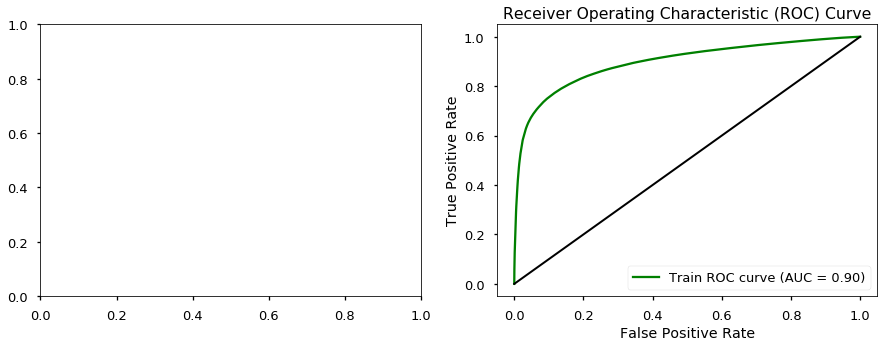

Train Roc_Auc Score: 90%
Train Accuracy Score: 87%


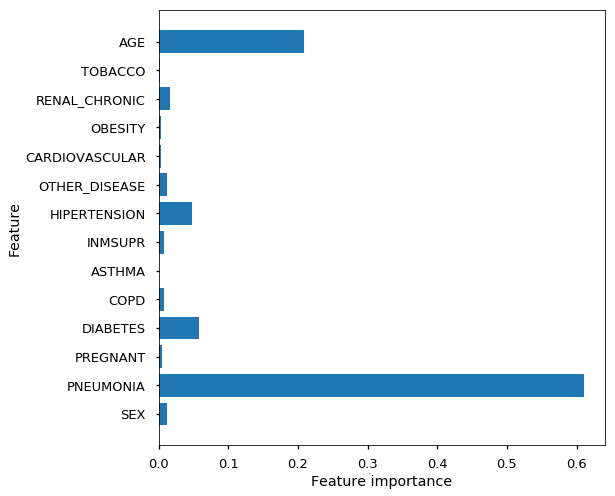

In [96]:
model_results(best_forest_bal)

### XGBooster

In [97]:
# Instantiate XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit XGBClassifier
xgb_model.fit(X_train, y_train)

# Predict on training and test sets
training_preds = xgb_model.predict(X_train)
#test_preds = clf.predict(X_test)

# Accuracy of training and test sets
#training_accuracy = accuracy_score(y_train, training_preds)
#test_accuracy = accuracy_score(y_test, test_preds)

#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))

In [98]:
print("Results for best Random Forest with XGBoost:\n")

print_metrics(y_train, training_preds)

Results for best Random Forest with XGBoost:

Precision Score: 0.8213143088294782
Recall Score: 0.6044915993964286
Accuracy Score: 0.9002384941311488
F1 Score: 0.6964168086093256


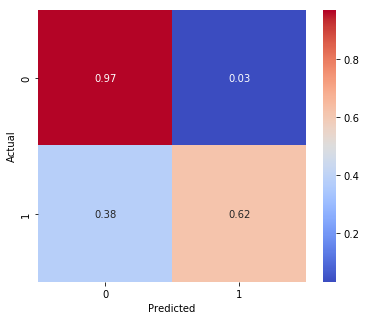

In [99]:
cm = confusion_matrix(y_train, ypreds_train_bestfor)
# Normalize
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='coolwarm')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

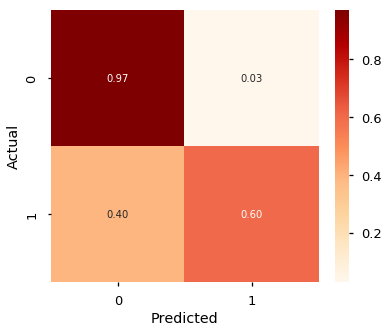

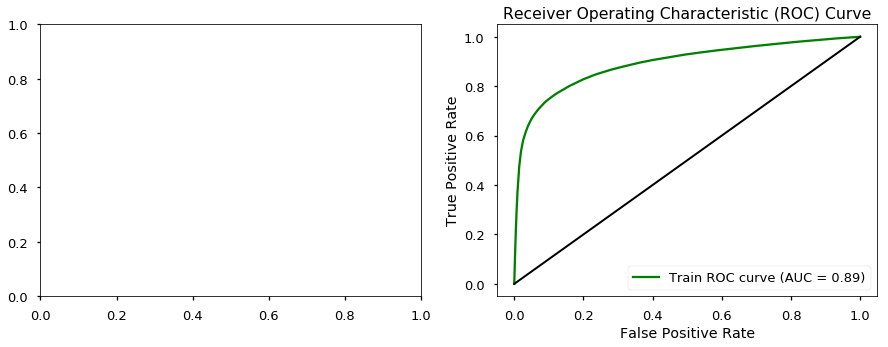

Train Roc_Auc Score: 89%
Train Accuracy Score: 90%


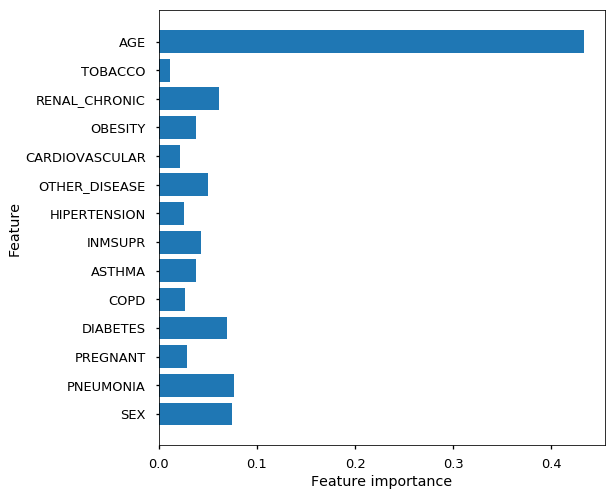

In [100]:
model_results(xgb_model)

# To draw some conclusions:
Now in order to draw some conclusions let us look at the results of the different models together and we will plot the ROC curve for all the different models we saw.
<br>Once we can identify the best model we can see what the most important features were for that model.

In [101]:
models=[clf, clf_bal, logreg, forest, best_forest, best_forest_bal, xgb_model]

AUC for DecisionTreeClassifier(criterion='entropy'): 0.9025045896507035
-------------------------------------------------------------------------------------
AUC for DecisionTreeClassifier(class_weight='balanced', criterion='entropy'): 0.9025045896507036
-------------------------------------------------------------------------------------
AUC for LogisticRegression(max_iter=500): 0.8680759981305924
-------------------------------------------------------------------------------------
AUC for RandomForestClassifier(random_state=19): 0.9006770642026405
-------------------------------------------------------------------------------------
AUC for RandomForestClassifier(min_samples_leaf=6, min_samples_split=5, n_estimators=30,
                       random_state=19): 0.8952095323294045
-------------------------------------------------------------------------------------
AUC for RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       min_samples_split=5, n_e

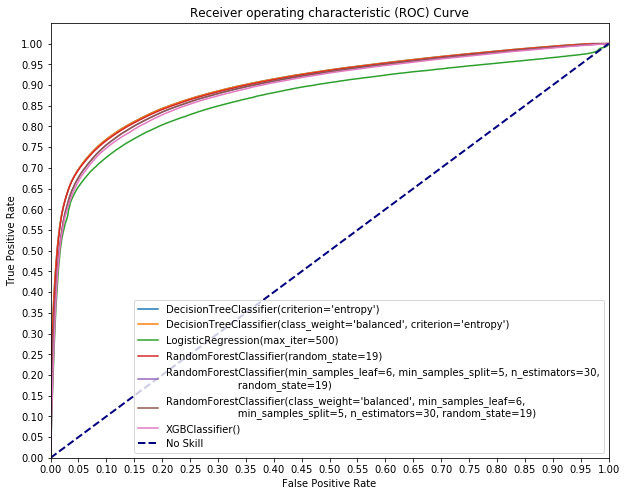

In [102]:
# Now let's compare a few different regularization performances on the dataset:
#weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
#names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set1')

plt.figure(figsize=(10,8))

for i in (models):
    
    yhat = i.predict_proba(X_train)
    yhat = yhat[:, 1]
    #fpr, tpr, thresholds= roc_curve(y_train, yhat)
    fpr, tpr, thresholds = roc_curve(y_train, yhat)
    #plot_roc_curve(clf, y_test, yhat)
    # plot the roc curve for the model
#    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, label=i)
# axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
# show the plot
    # Fit a model
    # Predict
#    y_hat_train = i.predict(X_train)

#    y_score = i.fit(X_train, y_train).decision_function(X_test)

#    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(i, auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
#    plt.plot(fpr, tpr,
#             lw=lw, label='ROC curve {}'.format(i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

DecisionTreeClassifier(criterion='entropy')
Precision Score: 0.841324314316936
Recall Score: 0.6303599098702863
Accuracy Score: 0.9075252455388021
F1 Score: 0.7207213480016711


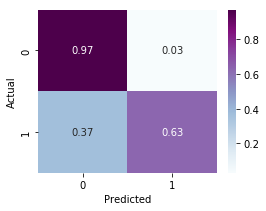

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
Precision Score: 0.6343894367448472
Recall Score: 0.7730788229005258
Accuracy Score: 0.8727079202594489
F1 Score: 0.6969010287206107


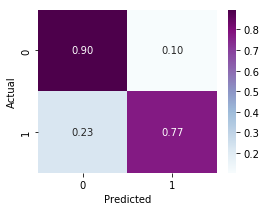

LogisticRegression(max_iter=500)
Precision Score: 0.8136729717747894
Recall Score: 0.5961146785576539
Accuracy Score: 0.8977075360046726
F1 Score: 0.6881070378311248


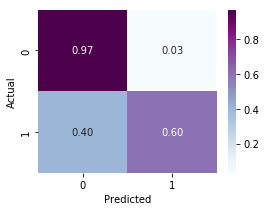

RandomForestClassifier(random_state=19)
Precision Score: 0.8339961468441239
Recall Score: 0.6385541353434334
Accuracy Score: 0.9075214029910392
F1 Score: 0.7233052682407134


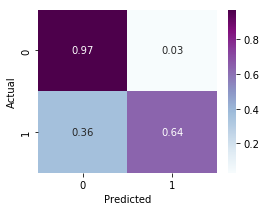

RandomForestClassifier(min_samples_leaf=6, min_samples_split=5, n_estimators=30,
                       random_state=19)
Precision Score: 0.8210321516308928
Recall Score: 0.619628248763423
Accuracy Score: 0.9024313080544925
F1 Score: 0.7062520968220855


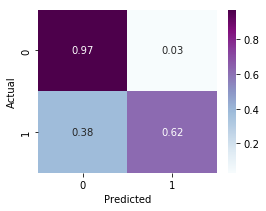

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       min_samples_split=5, n_estimators=30, random_state=19)
Precision Score: 0.615855114623133
Recall Score: 0.7678280227624893
Accuracy Score: 0.8653917093189468
F1 Score: 0.6834958122893721


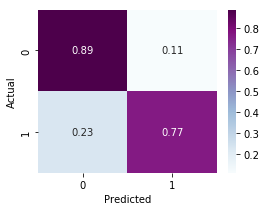

XGBClassifier()
Precision Score: 0.8213143088294782
Recall Score: 0.6044915993964286
Accuracy Score: 0.9002384941311488
F1 Score: 0.6964168086093256


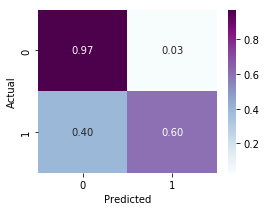

In [103]:
for i in models:
    preds=i.predict(X_train)
    print(i)
    print_metrics(y_train, preds)
    cm = confusion_matrix(y_train, preds)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='BuPu')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [104]:
models_fi=[clf, clf_bal, forest, best_forest, best_forest_bal, xgb_model]

AttributeError: 'bool' object has no attribute 'all'

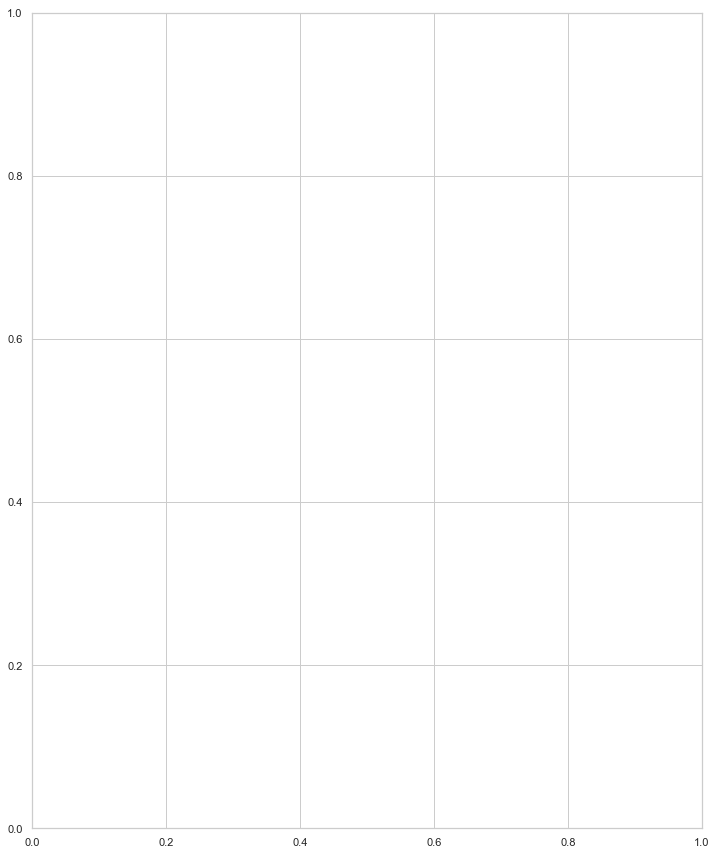

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 15))
for i in (models_fi):
    n_features = X_train.shape[1]
    sns.barplot(x=range(n_features), y=(i.feature_importances_), data=df)
    sns.yticks(np.arange(n_features), X_train.columns.values)
#sns.barplot(x="total", y="abbrev", data=crashes,
#            label="Total", color="b")

# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
#sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend (loc="lower right", frameon=True)
ax.set(ylabel="features", xlabel="Feature Importance")

In [ ]:
g = sns.catplot(
    data=penguins, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

In [ ]:
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    #not sure why when I add np.sort in front of model feature it changes
    plt.barh(range(n_features), (model.feature_importances_), align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
for i in (models):

### Threshold Chapter (we will see if it makes sense to include it)

Now I have to figure out how to decrease this famous threshold in decision trees.

First ROC curve

In [ ]:
yhat = clf.predict_proba(X_test)
yhat = yhat[:, 1]
#fpr, tpr, thresholds= roc_curve(y_train, yhat)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
#plot_roc_curve(clf, y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
...
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='DecisionTree')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### Precision-Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve
# predict probabilities
yhat = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Tree')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
...
# define thresholds
thresholds = np.arange(0, 1, 0.001)

In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
     return (pos_probs >= threshold).astype('int')

In [ ]:
...
# evaluate each threshold
yhat = clf.predict_proba(X_test)
probs = yhat[:, 1]
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

In [ ]:
...
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

In [ ]:
precision_, recall_, proba = precision_recall_curve(y_test, yhat[:, -1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')

In [ ]:
optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in yhat[:, -1]]

In [ ]:
recall_score(y_test, roc_predictions)

In [ ]:
f1_score(y_test, roc_predictions)

In [ ]:
precision_score(y_test, roc_predictions)

In [ ]:
accuracy_score(y_test, roc_predictions)

In [ ]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, yhat), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, yhat), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, yhat), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, yhat), f1_score(y_test, roc_predictions)))

In [ ]:
recall_score(y_test, yhat[:, -1])

In [ ]:
print_metrics(y_test, yhat[:, -1])

### Code from Eva model Results

In [ ]:
def model_results(model):
    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
        # Create Confusion Matrix for the test set
        plot_confusion_matrix(model, X_train, y_train, normalize = 'true', ax=ax1,  cmap = 'Greens')
        ax1.grid(False)
        ax1.set_title("Train Confusion Matrix")
        # Create Roc curve for the test and train for TP and FP rates
        plot_roc_curve(model, X_train, y_train, ax=ax2, color='green', name ='Train ROC curve')
#        plot_roc_curve(model, X_test, y_test, ax=ax2, color = ‘blue’, name ='Test ROC curve' )
        ax2.plot([0, 1], [0, 1], color='black', lw=2, linestyle='-')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
        plt.show()
        #Create a classification report
        y_pred = model.predict(X_train)
        print(classification_report(y_train, y_pred))
        ######***NEW LINE*** Print CV ROC_AUC score, and roc_auc score for test/train
        #Print CV ROC_AUC score
        roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train,
                                        cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        print(f"Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.0%}")
        #print roc_auc for test and train
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        print(f"Train Roc_Auc Score: {roc_score_train :.0%}")
#        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
#        print(f”Test Roc_Auc Score: {roc_score_test :.0%}“)
        accuracy_train = model.score(X_train, y_train)
#        accuracy_test = model.score(X_test, y_test)
        print(f"Train Accuracy Score: {accuracy_train :.0%}")
#        print(f”Test Accuracy Score: {accuracy_test :.0%}“)